In [1]:
import datetime
import pandas
import seaborn as sns
from davitpy import pydarn
from davitpy import gme
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter, MinuteLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
startDate = datetime.datetime(2011,6,8,0,0)#datetime.datetime(2011,4,12,0,0)#
endDate = datetime.datetime(2011,6,9,0,0)#datetime.datetime(2011,4,12,23,59)#

selDtList = [ datetime.datetime(2011,6,8,4,20), datetime.datetime(2011,6,8,6,0) ]

In [3]:
# read data from different sources
# OMNI data
omnData=gme.ind.omni.readOmni(startDate, endDate)
# AE data
aeData=gme.ind.readAe(startDate, endDate, res=1)
#Now we do the SYM and ASYM indices...
symasy=gme.ind.symasy.readSymAsy(\
        sTime=startDate, eTime=endDate,\
        symh=None, symd=None, asyh=None,\
        asyd=None)
# convert to dataframes
omnDF = pandas.DataFrame( {'date' : [ omnData[x].time for x in range(len(omnData))],
                           'ief' : [ omnData[x].e for x in range(len(omnData))],
                          'Bz' : [ omnData[x].bzm for x in range(len(omnData))] } )
aeDF = pandas.DataFrame( {'date' : [ aeData[x].time for x in range(len(aeData))],
                           'ae' : [ aeData[x].ae for x in range(len(aeData))],
                          'ao' : [ aeData[x].ao for x in range(len(aeData))],
                          'au' : [ aeData[x].au for x in range(len(aeData))],
                          'al' : [ aeData[x].al for x in range(len(aeData))] } )
symDF = pandas.DataFrame( {'date' : [ symasy[x].time for x in range(len(symasy))],
                           'symh' : [ symasy[x].symh for x in range(len(symasy))],
                          'asyh' : [ symasy[x].asyh for x in range(len(symasy))],
                          'symd' : [ symasy[x].symd for x in range(len(symasy))],
                          'asyd' : [ symasy[x].asyd for x in range(len(symasy))] } )

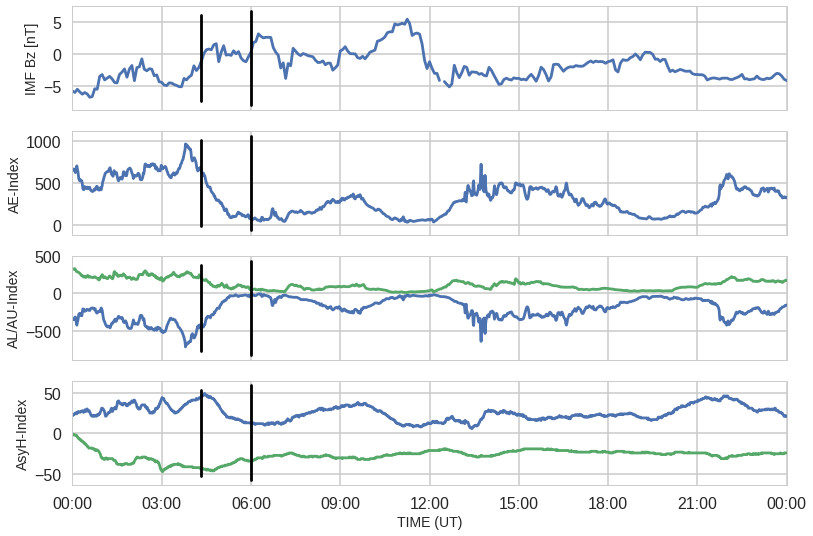

In [4]:
# Setup Fig
sns.set_style("whitegrid")
sns.set_context("poster")
f = plt.figure(figsize=(12, 8))
f, axArr = plt.subplots(4, sharex=True)
axArr[0].plot(omnDF["date"].values, omnDF["Bz"].values)
axArr[1].plot(aeDF["date"].values, aeDF["ae"].values)
axArr[2].plot(aeDF["date"].values, aeDF["al"].values)
axArr[2].plot(aeDF["date"].values, aeDF["au"].values)
axArr[3].plot(symDF["date"].values, symDF["asyh"].values)
axArr[3].plot(symDF["date"].values, symDF["symh"].values)

# ax labels
axArr[0].set_ylabel("IMF Bz [nT]", fontsize=14)
axArr[1].set_ylabel("AE-Index", fontsize=14)
axArr[2].set_ylabel("AL/AU-Index", fontsize=14)
axArr[3].set_ylabel("AsyH-Index", fontsize=14)
# x-label
axArr[3].set_xlabel("TIME (UT)", fontsize=14)

# format the axes
axArr[0].set_xlim( [startDate, endDate] )
axArr[1].set_xlim( [startDate, endDate] )
axArr[2].set_xlim( [startDate, endDate] )
axArr[3].set_xlim( [startDate, endDate] )

axArr[0].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[1].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[2].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
axArr[3].get_xaxis().set_major_formatter(DateFormatter('%H:%M'))


# plot vertical lines
for sd in selDtList:
    for axx in axArr:
        axx.plot( [sd, sd], list(axx.get_ylim()), c='k' )

f.savefig( "../plots/gmag-" + startDate.strftime("%Y%m%d") + ".eps",bbox_inches='tight' )